# Stochastic models and optimization - Bandits - Problem set 2
## Sergio-Yersi Villegas Pelegrín
### *June 2022*

# 1. Gaussian processes

We import the relevant modules for this problem set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.linalg import cholesky
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy import stats

We define the squared exponential kernel and a function to produce a covariance matrix given a the squared exponential kernel function.

In [2]:
def se_kernel(x, y, lamda, s_f):
    return(s_f**2)*np.exp(-((x - y)**2)/(2*(lamda**2)))

def cov_matrix(x, y, lamda, s_f, s_n, noisy=True):
    cov_mat = np.zeros([len(x), len(y)])
    for i in range(len(x)):
        for j in range(len(y)):
            cov_mat[i][j] = se_kernel(x[i], y[j], s_f, lamda)
            if i==j and noisy==True:
                cov_mat[i][j] += s_n**2
    return cov_mat  

We define the parameters of this first problem.

In [12]:
X = np.linspace(-7, 7, 100)
X_train = np.random.uniform(-7,7,20)
parameters = [[1, 1, 0.1], [0.3, 1.08, 0.00005],  [3.0, 1.16, 0.89]]
epsilon = 1e-10

We do NOT add noise in order to recreate Figure 2.2-a from the Rasmussen & Willams (2006) book.

In [13]:
outputs = np.random.multivariate_normal(mean = np.zeros(100), \
                                        cov = cov_matrix(X, X, parameters[0][0], parameters[0][1],parameters[0][2],\
                                                        noisy=False),\
                                        size=3)

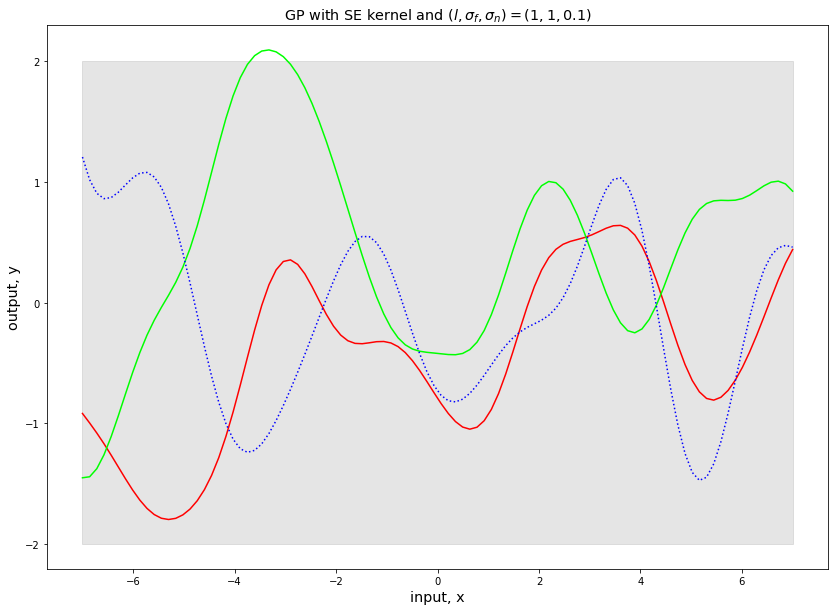

In [14]:
plt.figure(figsize=(14,10))
plt.plot(X, outputs[0], color = "red")
plt.plot(X, outputs[1], color = "lime")
plt.plot(X, outputs[2], color = "blue", linestyle='dotted')
plt.fill_between(X, -2, 2, color = "grey", alpha=0.2)
plt.title(r'GP with SE kernel and $(l,\sigma_f,\sigma_n) = (1,1,0.1)$', fontsize='x-large')
plt.xlabel('input, x', fontsize='x-large')
plt.ylabel('output, y', fontsize='x-large')
plt.show()

We define the function to compute the posteriors and recreate Figure 2.5 from the Rasmussen & Willams (2006) book.

In [15]:
def posteriors(X_train, X, s_f, lamda, s_n, epsilon):
    
    # Three covariance matrices that will be needed: following algorithm 2.1,
    # the first covariance matrix does include noise, while the rest do NOT include it.
    
    cov_mat = cov_matrix(X_train, X_train, lamda, s_f, s_n)
    cov_mat_traintest = cov_matrix(X_train, X, lamda, s_f, s_n, noisy=False)
    cov_mat_test = cov_matrix(X, X, lamda, s_f, s_n, noisy=False)

    # Outputs for the training data: 20 samples from U(-7,7).
    output = np.random.multivariate_normal(np.zeros(len(X_train)), cov = cov_mat, size=1)

    # Cholesky with small numerical constant on diagonal
    L = np.linalg.cholesky(cov_mat+epsilon*np.eye(cov_mat.shape[0]))
    
    # Predictive mean
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, output.T))
    mu = np.dot(cov_mat_traintest.T, alpha)
    
    # Predictive variance
    v = np.linalg.solve(L, cov_mat_traintest)
    variance = np.diag(cov_mat_test - np.dot(v.T, v))

    return [output.flatten(), mu.flatten(), variance.flatten()]    

We loop over the parameters and plot the results.

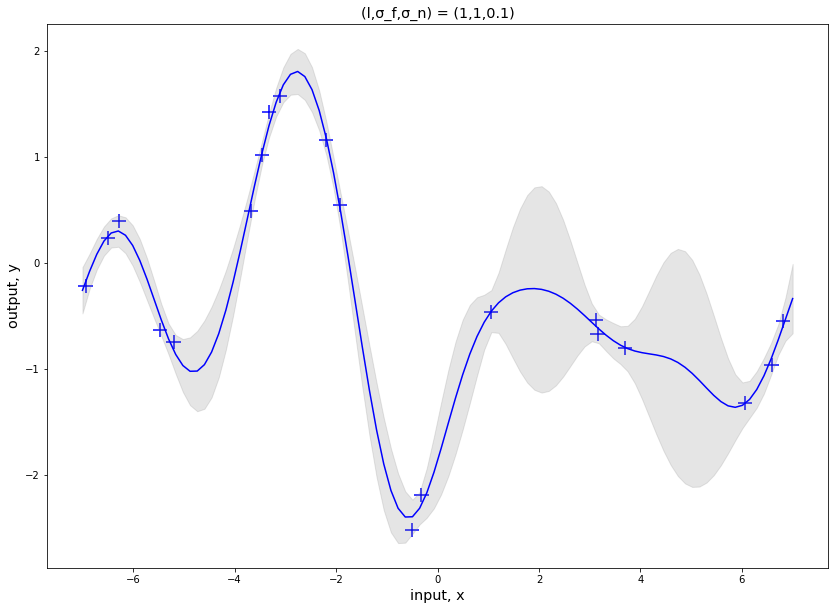

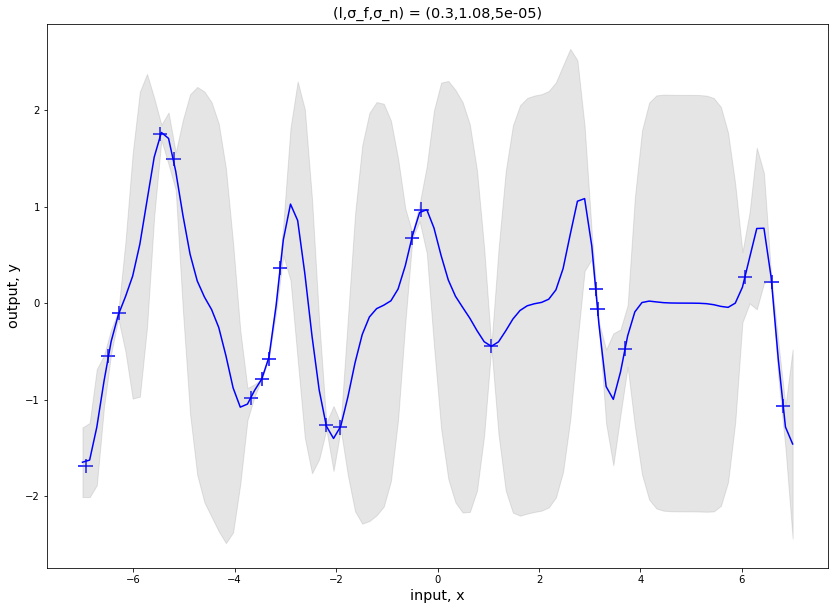

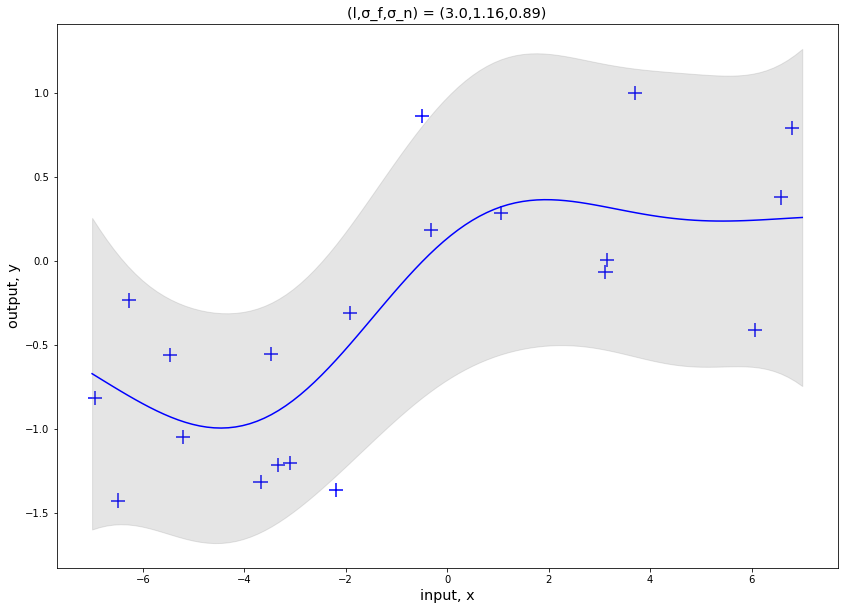

In [16]:
for param in parameters:
    posterior_results = posteriors(X_train=X_train, X=X, s_f=param[0], lamda=param[1],\
                               s_n=param[2], epsilon=epsilon)
    plt.figure(figsize=(14,10))
    plt.scatter(X_train, posterior_results[0], c='blue', marker = "+", sizes = [200]*len(X_train))
    plt.plot(X, posterior_results[1], c='blue')
    plt.title('(l,σ_f,σ_n) = ('+str(param[0])+','+str(param[1])+','+str(param[2])+')', \
              fontsize='x-large')

    plt.xlabel('input, x', fontsize='x-large')
    plt.ylabel('output, y', fontsize='x-large')
    plt.fill_between(X, posterior_results[1]-2*np.sqrt(posterior_results[2]), \
                     posterior_results[1]+2*np.sqrt(posterior_results[2]), color = "gray", alpha = 0.2)
    plt.show()

# 2. Bayesian optimization

We define the parameters of this second problem.

In [15]:
x1 = np.linspace(-5, 10, 100)
x2 = np.linspace(0, 15, 100)
a = 1
b = 5.1/(4*np.pi**2)
c = 5/np.pi
r = 6
s = 10
t = 1/(8*np.pi)
size = 5
model_gp = GaussianProcessRegressor()
global_min = 0.397887
acq_list = ['UCB','PI','EI']
exploration_parameters = {'UCB':[0.05,2.5,5],'PI':[0.005,0.5,1],'EI':[0.005,0.5,1]}

We define the functions to be used in the optimization process. Since we want to minimize the function, we define it already with a minus sign, in order to not change anything during the optimization process. Hence, by maximizing the function multiplied by a -1, we are minimizing the function itself.

In [16]:
def branin(x1,x2,a,b,c,r,s,t):
    # Computes the objective function of our case: Branin (with the -1 as explained above)
    return -(a*(x2-b*(x1**2)+c*x1-r)**2 + s*(1-t)*np.cos(x1) + s)

def generate_data(x1,x2,size,a,b,c,r,s,t):
    # Generates training and test Xs, together with the corresponding y (output)
    x1_sample = np.random.uniform(-5,10,size)
    x2_sample = np.random.uniform(0,15,size)
    X_train = np.array([x1_sample,x2_sample]).T
    output = np.array([branin(x[0],x[1],a,b,c,r,s,t) for x in X_train])
    X_test = np.array([[row, col] for row in x1 for col in x2])
    return X_train, X_test, output

In [17]:
def acquisition_functions(X_train,X_test,acq,model,mu,std,exp_param):
    # UCB acquisition function
    if acq == 'UCB':
        max_index = np.argmax(np.array(mu) + exp_param*np.array(std))
        return X_test[max_index]
    else:
        # Probability Improvement or Expected Improvement acquisition functions
        output = model.predict(X_train)
        max_val = max(output)
        Z = (mu - max_val - exp_param)/(std + 0.000001)
        if acq == 'PI':
            max_index = np.argmax(stats.norm.cdf(Z))
            return X_test[max_index]
        elif acq == 'EI':
            max_index = np.argmax((mu - max_val - exp_param)*stats.norm.cdf(Z) + std*stats.norm.pdf(Z))
            return X_test[max_index]
        
def bayesian_opt(train_X,test_X,output,a,b,c,r,s,t,model,acq,exp_param,global_min):
    # We redefine it to the first 5 original values, since we will be performing
    # several iterations for each acquisition function and exploration parameter combination
    # and. Since we have to update the training Xs and the outputs for each of the 100 iterations,
    # we have to redefine it everytime we change acquisition function or parameter, in order for it
    # to always start with the 5 original points. Moreover, we define the Xs and the output
    # outside of the function, in order to have the same random points and have comparable results.
    train_X = train_X[0:5]
    output = output[0:5]
    squared_errors = []
    for i in range(100):
        # Optimization process performed
        model.fit(train_X,output)
        mu, std = model.predict(test_X, return_std=True)
        new_x = acquisition_functions(train_X,test_X,acq,model,mu,std,exp_param)
        new_output = branin(new_x[0],new_x[1],a,b,c,r,s,t)
        train_X = np.vstack((train_X, [new_x]))
        output = np.append(output, new_output)
        squared_errors.append((new_output - global_min)**2) 
    return squared_errors

def plots(results,title_name):
    # Plot all results together
    tickers = results.columns
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30, 20))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title_name, fontsize=30, y=0.95)

    # loop through tickers and axes
    for ticker, ax in zip(tickers, axs.ravel()):
        # filter df for ticker and plot on specified axes
        results[ticker].plot(ax=ax, c='darkviolet')

        # chart formatting
        ax.set_title(ticker.upper())
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Squared error")
    plt.show()  

We loop over all the acquisition functions and their exploration parameters and store the results. Then, we save the results and plot them. Note that we define the Xs and the output outside of the loop, in order to have comparable results (since all algorithms will start with the same random points). We could also have achieved this by setting a random seed.

In [18]:
all_results = []
train_X, test_X, output = generate_data(x1=x1,x2=x2,size=size,a=a,b=b,c=c,r=r,s=s,t=t)
for acq in acq_list:
    for param in exploration_parameters[acq]:
        print(acq,param)
        squared_errors = bayesian_opt(train_X=train_X,test_X=test_X,output=output,a=a,b=b,c=c,r=r,s=s,t=t,\
                    model=model_gp,acq=acq,exp_param=param,global_min=global_min)
        all_results.append(squared_errors)

UCB 0.05
UCB 2.5
UCB 5
PI 0.005
PI 0.5
PI 1
EI 0.005
EI 0.5
EI 1


In [19]:
results_df = pd.DataFrame(all_results).T
results_df.columns = [i+'_'+str(j) for i in acq_list for j in exploration_parameters[i]]
results_df

,UCB_0.05,UCB_2.5,UCB_5,PI_0.005,PI_0.5,PI_1,EI_0.005,EI_0.5,EI_1
0,1282.279553,1759.778702,1900.933565,95188.899246,95188.899246,95188.899246,2051.690567,2051.690567,2051.690567
1,21394.935683,23131.639080,24073.053073,43796.796433,42047.838012,40352.959965,25066.863538,25066.863538,25066.863538
2,20877.806208,19468.938994,19468.938994,17842.950415,16133.489688,14554.370799,18776.459961,18776.459961,18776.459961
3,22734.782604,24958.692007,26131.816617,6189.623245,5115.161959,4196.420590,26131.816617,26131.816617,26131.816617
4,1161.194388,1161.194388,1161.194388,1759.778702,1282.279553,1003.966853,1161.194388,1161.194388,1161.194388
...,...,...,...,...,...,...,...,...,...
95,1.075888,0.647021,0.647021,58.713739,224.007213,388.353273,84.775985,324.198606,93.014167
96,1.075888,0.647021,0.647021,1720.122838,359.426361,269.606144,273.859769,1.143990,13724.439466
97,1.075888,0.647021,0.647021,251.625371,9.938003,77.185764,12092.836099,2.546789,65.664025
98,1.075888,0.647021,0.647021,301.941495,236.739150,423.205917,0.791132,251.193479,102.232194


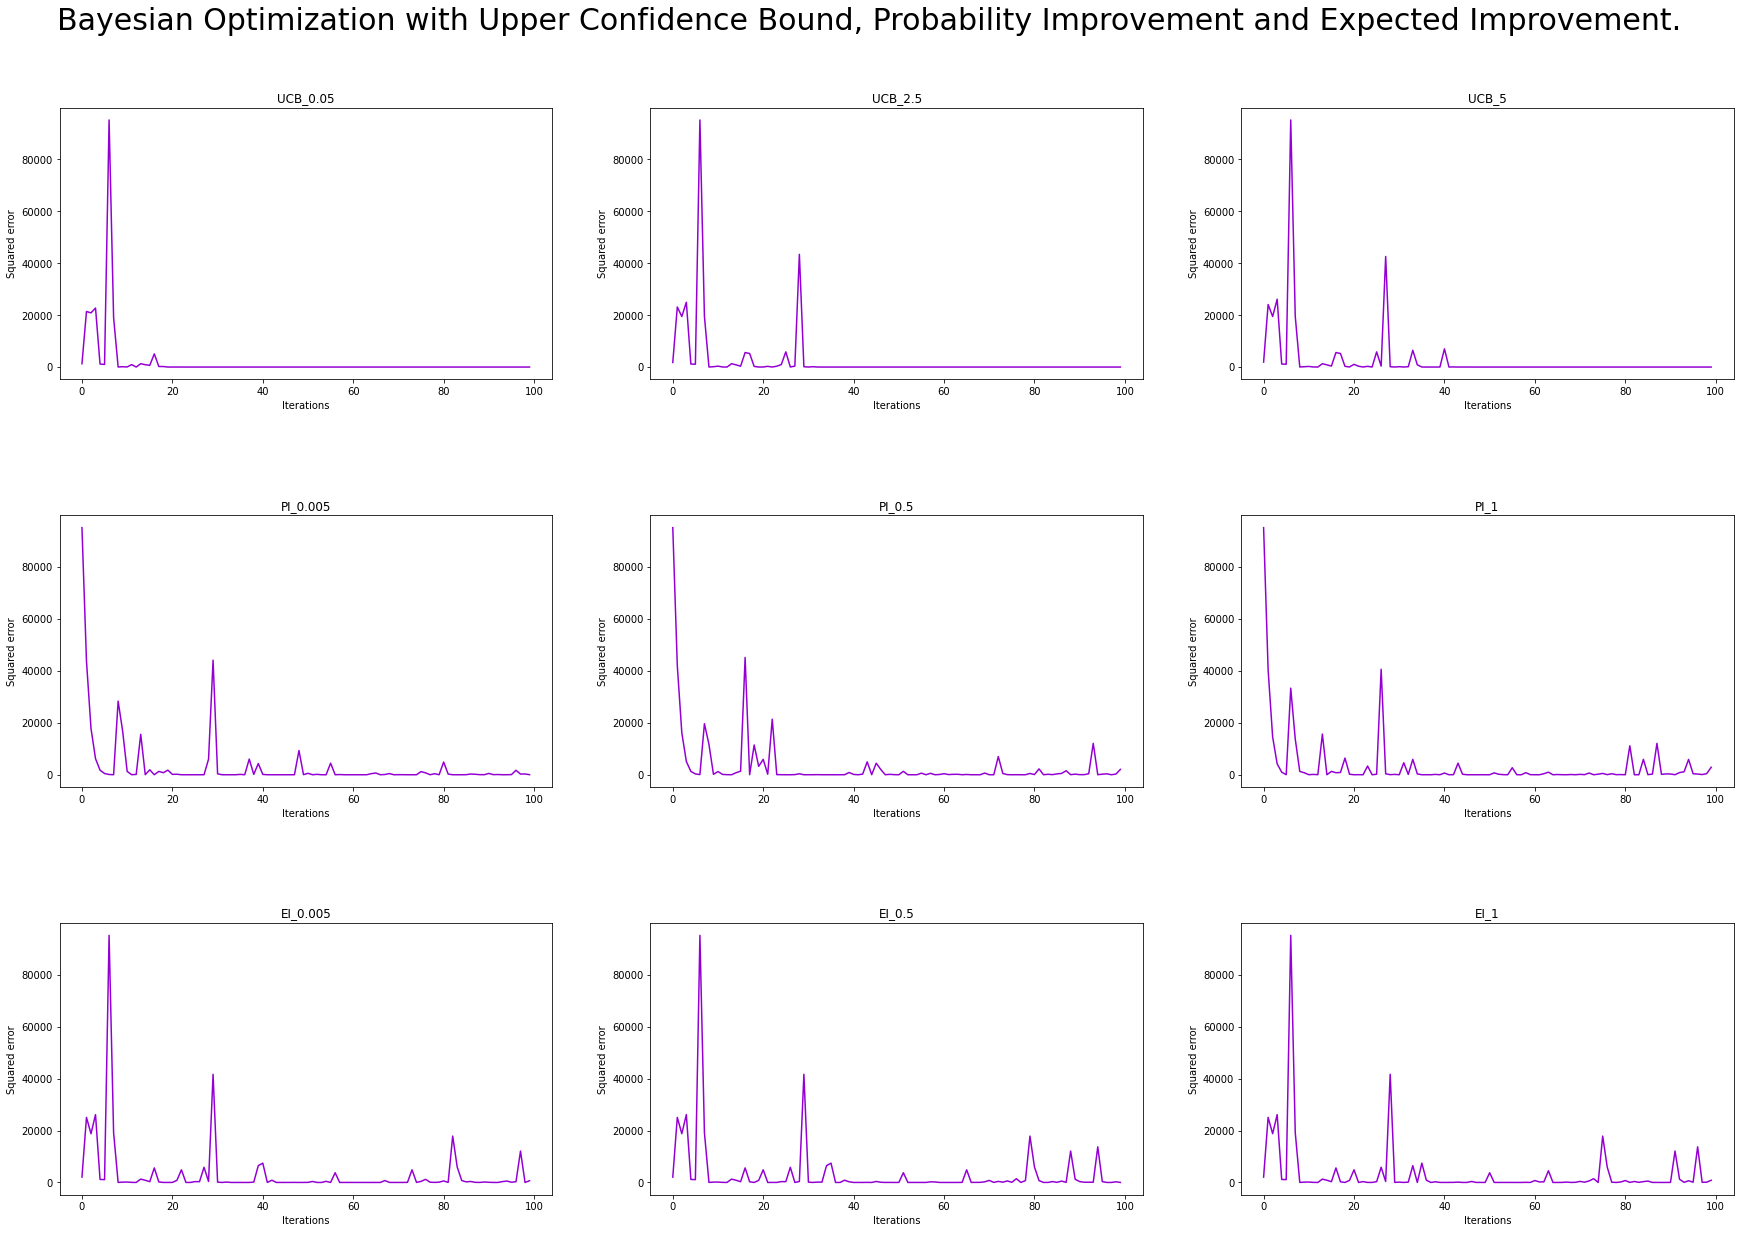

In [20]:
plots(results_df,\
      'Bayesian Optimization with Upper Confidence Bound, Probability Improvement and Expected Improvement.')